In [1]:
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 1

In [2]:
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split
from src.data_loader import *
# # from src.training import *
# from src.visualization import *
# from src.evaluation import *
from sklearn.preprocessing import label_binarize
from PIL import Image
from IPython.display import Image, display
from src.pipeline import *
import joblib
from src.convert_graphml_to_pyg_data_multithread import *
from tqdm import tqdm

import networkx as nx
%aimport src.data_loader
%aimport src.visualization
%aimport src.training
%aimport src.evaluation
%aimport src.pipeline
%aimport src.convert_graphml_to_pyg_data_multithread

tqdm.pandas()

In [18]:
features = [
            "faces", "edges", "vertices", "quantity",
            "height", "width", "depth", "volume", "area",
            "bbox_height", "bbox_width", "bbox_depth", "bbox_volume",
            "bbox_area",
        ]
data = pd.read_csv("./data/synced_dataset_final.csv")
# data = remove_minority_class(data)
# data[["item_id", "is_cnc", "multiclass_labels"]].head()
data

,item_id,faces,edges,vertices,step_file,depth,width,height,area,volume,...,material_id,post_processing_id,download_file_url,technology_name,is_cnc,multiclass_labels,graphml_file,pointcloud_file,binary_fold,multiclass_fold
0,100035,216.0,637.0,423.0,E:\gnn_data\step_files\100035_MakerVerse_Sampl...,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100035_MakerVerse_Sa...,E:\gnn_data\pointcloud_files\100035_MakerVerse...,5.0,6.0
1,100036,216.0,637.0,423.0,E:\gnn_data\step_files\100036_MakerVerse_Sampl...,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100036_MakerVerse_Sa...,E:\gnn_data\pointcloud_files\100036_MakerVerse...,5.0,2.0
2,100040,216.0,637.0,423.0,E:\gnn_data\step_files\100040_00048125_Stator_...,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100040_00048125_Stat...,E:\gnn_data\pointcloud_files\100040_00048125_S...,8.0,6.0
3,100041,10.0,24.0,16.0,E:\gnn_data\step_files\100041_00048495_Table_L...,60.000000,60.000000,110.000000,25498.294788,198807.075004,...,1311,[277],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100041_00048495_Tabl...,E:\gnn_data\pointcloud_files\100041_00048495_T...,1.0,9.0
4,100042,12.0,22.0,14.0,E:\gnn_data\step_files\100042_00048569_Seal_Ho...,68.503800,49.991283,68.503800,21639.093985,37803.606058,...,1315,[277],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100042_00048569_Seal...,E:\gnn_data\pointcloud_files\100042_00048569_S...,9.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62193,99989,216.0,637.0,423.0,E:\gnn_data\step_files\99989_MakerVerse_Sample...,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,804,[277],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\99989_MakerVerse_Sam...,E:\gnn_data\pointcloud_files\99989_MakerVerse_...,1.0,7.0
62194,99990,60.0,136.0,73.0,E:\gnn_data\step_files\99990_240332A01.step,71.000000,100.000000,100.000000,33202.761028,248500.951622,...,1301,[277],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\99990_240332A01.graphml,E:\gnn_data\pointcloud_files\99990_240332A01.txt,2.0,1.0
62195,99991,216.0,637.0,423.0,E:\gnn_data\step_files\99991_MakerVerse_Sample...,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\99991_MakerVerse_Sam...,E:\gnn_data\pointcloud_files\99991_MakerVerse_...,9.0,0.0
62196,99993,216.0,637.0,423.0,E:\gnn_data\step_files\99993_MakerVerse_Sample...,163.662476,185.610681,163.662476,208702.010756,963533.514386,...,813,[1000],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\99993_MakerVerse_Sam...,E:\gnn_data\pointcloud_files\99993_MakerVerse_...,0.0,5.0


In [19]:
data.binary_fold.value_counts()

binary_fold
5.0    6220
1.0    6220
2.0    6220
6.0    6220
3.0    6220
0.0    6220
7.0    6220
4.0    6220
8.0    6219
9.0    6219
Name: count, dtype: int64

In [13]:
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

In [14]:
def assign_folds_based_on_labels(dataframe, label_column, num_folds=5,
                                 random_state=42):
    """
    Assign folds based on the specified label column.
    Uses StratifiedKFold to ensure balanced distribution of labels across folds.
    """
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True,
                          random_state=random_state)
    fold_assignments = np.zeros(len(dataframe))

    for fold_idx, (_, val_idx) in enumerate(
            skf.split(dataframe, dataframe[label_column])):
        fold_assignments[val_idx] = fold_idx

    return fold_assignments

In [15]:
data['binary_fold'] = assign_folds_based_on_labels(
        data,
        'is_cnc',
        num_folds=10,
        random_state=42,
    )
data['multiclass_fold'] = assign_folds_based_on_labels(
    data,
    'multiclass_labels',
    num_folds=10,
    random_state=42,
)

C:\Users\phanm\AppData\Local\Temp\ipykernel_2612\2520173051.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['binary_fold'] = assign_folds_based_on_labels(
C:\Users\phanm\AppData\Local\Temp\ipykernel_2612\2520173051.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['multiclass_fold'] = assign_folds_based_on_labels(


In [16]:
data.binary_fold.value_counts()

binary_fold
5.0    6220
1.0    6220
2.0    6220
6.0    6220
3.0    6220
0.0    6220
7.0    6220
4.0    6220
8.0    6219
9.0    6219
Name: count, dtype: int64

In [17]:
data.to_csv("./data/synced_dataset_final.csv", index=False)

In [9]:
global_features = data.iloc[0][features]
global_features_tensor = torch.tensor(global_features, dtype=torch.float).unsqueeze(0)
global_features_tensor.shape

C:\Users\phanm\AppData\Local\Temp\ipykernel_11484\328709359.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  global_features_tensor = torch.tensor(global_features, dtype=torch.float).unsqueeze(0)


torch.Size([1, 14])

In [48]:
data.describe()

,item_id,faces,edges,vertices,depth,width,height,area,volume,bbox_depth,bbox_height,bbox_width,bbox_area,bbox_volume,quantity,material_id,is_cnc,multiclass_labels,binary_fold,multiclass_fold
count,63097.000000,63097.000000,63097.000000,63097.000000,63097.000000,63097.000000,63097.000000,6.309700e+04,6.309700e+04,63097.000000,63097.000000,63097.000000,63097.000000,6.309700e+04,63097.000000,63097.000000,63097.000000,63097.000000,63097.000000,63097.000000
mean,74845.637320,121.088039,317.766597,202.101843,113.152431,121.479545,90.488817,9.636720e+04,5.217243e+05,59.655295,94.773194,168.422259,59.655295,3.175008e+06,50.397087,977.290933,0.641314,5.618096,4.498122,4.499596
std,29460.858056,232.663474,617.101272,394.832912,189.929456,219.425161,159.879791,4.124573e+05,2.976333e+06,94.396903,143.813229,272.199681,94.396903,5.816266e+07,331.487288,12463.557772,0.479619,6.184864,2.871713,2.871675
min,23481.000000,1.000000,2.000000,1.000000,0.010000,0.009340,0.009321,2.125739e-04,2.325268e-07,0.008472,0.006504,0.009054,0.008472,4.989171e-07,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,49896.000000,23.000000,57.000000,37.000000,21.999955,23.562925,20.000000,5.954573e+03,9.228909e+03,15.000000,21.939146,37.865414,15.000000,2.587463e+04,1.000000,411.000000,0.000000,2.000000,2.000000,2.000000
50%,74274.000000,45.000000,117.000000,76.000000,53.116226,60.000362,40.000000,1.688263e+04,3.768346e+04,29.499413,50.000000,90.000000,29.499413,1.286973e+05,2.000000,808.000000,1.000000,2.000000,4.000000,4.000000
75%,100060.000000,109.000000,292.000000,186.000000,124.000000,134.765717,99.048744,6.132620e+04,2.024626e+05,68.503799,105.000000,180.019394,68.503799,6.750000e+05,6.000000,1300.000000,1.000000,7.000000,7.000000,7.000000
max,125515.000000,2949.000000,8997.000000,8640.000000,5000.000000,5801.998535,5353.802307,2.905170e+07,9.966791e+07,2369.000000,2782.265625,6081.526194,2369.000000,9.832688e+09,9600.000000,809000.000000,1.000000,22.000000,9.000000,9.000000


In [41]:
# Define target directories
step_target_dir = Path(r"E:\gnn_data\step_files_final")
graphml_target_dir = Path(r"E:\gnn_data\graphml_files_final")

# Create target dirs if they don’t exist
os.makedirs(step_target_dir, exist_ok=True)
os.makedirs(graphml_target_dir, exist_ok=True)

# Loop through the DataFrame rows
for idx, row in tqdm(data2.iterrows()):
    step_src = Path(row['step_file'])
    graphml_src = Path(row['graphml_file'])

    # Move STEP file
    if step_src.exists():
        step_src.rename(step_target_dir / step_src.name)

    # Move GraphML file
    if graphml_src.exists():
        graphml_src.rename(graphml_target_dir / graphml_src.name)

63097it [00:27, 2261.34it/s]


binary_fold
6.0    6324
5.0    6317
1.0    6315
0.0    6315
2.0    6312
3.0    6311
7.0    6310
8.0    6305
4.0    6297
9.0    6291
Name: count, dtype: int64

In [4]:
train_data = data[data.binary_fold == 0].reset_index(drop=True)
X = train_data[features]
X_train, X_test, y_train_index, y_test_index = train_test_split(
            X,
            range(len(X)),
            test_size=0.2,
            random_state=42,
            stratify=train_data["is_cnc"],
        )

In [15]:
result_binary, result_multi = training_one_fold(dataset=data)

Training fold 0...
Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...
Training fold 6...
Training fold 7...
Training fold 8...
Training fold 9...


In [16]:
result_binary

,Fold 0,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9
accuracy,0.774322,0.762360,0.744817,0.754386,0.767145,0.783892,0.780702,0.789474,0.772727,0.775120
f1_macro,0.759934,0.741529,0.725581,0.736817,0.748903,0.769533,0.766913,0.774013,0.756577,0.759871
f1_weighted,0.775306,0.760722,0.744585,0.754603,0.766605,0.784580,0.781742,0.789474,0.772977,0.775699
roc_auc,0.832267,0.823100,0.817507,0.816992,0.831570,0.845355,0.844312,0.836582,0.810040,0.846106
average_precision,0.889847,0.876174,0.876118,0.869002,0.881544,0.894221,0.887809,0.881222,0.847006,0.894130


In [10]:
df_result = pd.DataFrame(result_binary)
df_result.T

,0,1
accuracy,0.774322,0.762360
f1_macro,0.759934,0.741529
f1_weighted,0.775306,0.760722
roc_auc,0.832267,0.823100
average_precision,0.889847,0.876174


In [6]:
features = [
    "faces", "edges", "vertices", "quantity",
    "height", "width", "depth", "volume", "area",
    "bbox_height", "bbox_width", "bbox_depth", "bbox_volume", "bbox_area",
]
X = data[features]


In [7]:
X_train, X_test, y_train_index, y_test_index = train_test_split(X, range(len(X)), test_size=0.2, random_state=42, stratify=data["multiclass_labels"])
y_multi_train = data["multiclass_labels"].iloc[y_train_index]
y_multi_test = data["multiclass_labels"].iloc[y_test_index]

y_binary_train = data["is_cnc"].iloc[y_train_index]
y_binary_test = data["is_cnc"].iloc[y_test_index]


params = {
    "n_estimators": randint(100, 300),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.3),
}

In [8]:
best_search_multi = randomizedsearchcv_xgboost(X_train, y_multi_train, params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   2.8s
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   2.4s
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   2.5s
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   2.7s
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   2.6s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   2.6s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   2.6s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   2.7s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   2.6s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   2.5

In [9]:
# Save model to disk
joblib.dump(best_search_multi, "./models/best_model_multi.pkl")

['./models/best_model_multi.pkl']

In [10]:
best_search_binary = randomizedsearchcv_xgboost(X_train, y_binary_train, params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   0.0s
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   0.0s
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   0.1s
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   0.1s
[CV] END learning_rate=0.12236203565420874, max_depth=7, n_estimators=114; total time=   0.1s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   0.1s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   0.1s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   0.1s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   0.1s
[CV] END learning_rate=0.22959818254342154, max_depth=7, n_estimators=120; total time=   0.1

In [11]:
# Save model to disk
joblib.dump(best_search_binary, "./models/best_model_binary.pkl")

['./models/best_model_binary.pkl']

In [12]:
# Load models from disk
best_search_multi = joblib.load("./models/best_model_multi.pkl")
best_search_binary = joblib.load("./models/best_model_binary.pkl")

# Multiclass predictions
y_multi_pred = best_search_multi.best_estimator_.predict(X_test)
y_multi_prob = best_search_multi.best_estimator_.predict_proba(X_test)

# Binary predictions
y_binary_pred = best_search_binary.best_estimator_.predict(X_test)
y_binary_prob = best_search_binary.best_estimator_.predict_proba(X_test)

In [19]:
from sklearn.metrics import roc_auc_score, average_precision_score

# Multiclass AUROC
auc_roc_multi = roc_auc_score(y_multi_test, y_multi_prob, multi_class='ovr', average='macro')

# Multiclass Average Precision
avg_precision_multi = average_precision_score(y_multi_test, y_multi_prob, average='macro')
display(auc_roc_multi, avg_precision_multi)

0.9159675993547275

0.6042723452036123

In [43]:
# Binary AUROC
auc_roc_binary = roc_auc_score(y_binary_test, y_binary_prob[:, 1])

# Binary Average Precision
avg_precision_binary = average_precision_score(y_binary_test, y_binary_prob[:, 1])
display(auc_roc_binary, avg_precision_binary)

0.9380131889158437

0.9580794635640363

In [41]:
y_binary_prob

array([[0.9459677 , 0.05403232],
       [0.04010487, 0.95989513],
       [0.04546088, 0.9545391 ],
       ...,
       [0.8093872 , 0.19061282],
       [0.01354468, 0.9864553 ],
       [0.9790657 , 0.02093427]], dtype=float32)

In [44]:
print("Multi-Class Model Evaluation")
metrics_multi = evaluate_classification(
    y_true=y_multi_test,
    y_pred=y_multi_pred,
    y_prob=y_multi_prob,
    # top_k=3
)
pprint(metrics_multi)
le = joblib.load("./models/label_encoder.pkl")
# print_classification_report(y_multi_test, y_multi_pred)

# df_multi_class_accuracy = compute_per_class_accuracy(y_multi_test, y_multi_pred, le)
# pprint(df_multi_class_accuracy)

Multi-Class Model Evaluation
{'accuracy': 0.7417630634224173,
 'average_precision': 0.6042723452036123,
 'f1_macro': 0.593230863615564,
 'f1_weighted': 0.7482129409505707,
 'roc_auc': 0.9159675993547275}


In [45]:
print("Binary Model Evaluation")
metrics_binary = evaluate_classification(
    y_true=y_binary_test,
    y_pred=y_binary_pred,
    y_prob=y_binary_prob,
)
pprint(metrics_binary)

# print_classification_report(y_binary_test, y_binary_pred)

Binary Model Evaluation
{'accuracy': 0.8742720382927802,
 'average_precision': 0.9580794635640363,
 'f1_macro': 0.8662770422115723,
 'f1_weighted': 0.8748459042431443,
 'roc_auc': 0.9380131889158437}


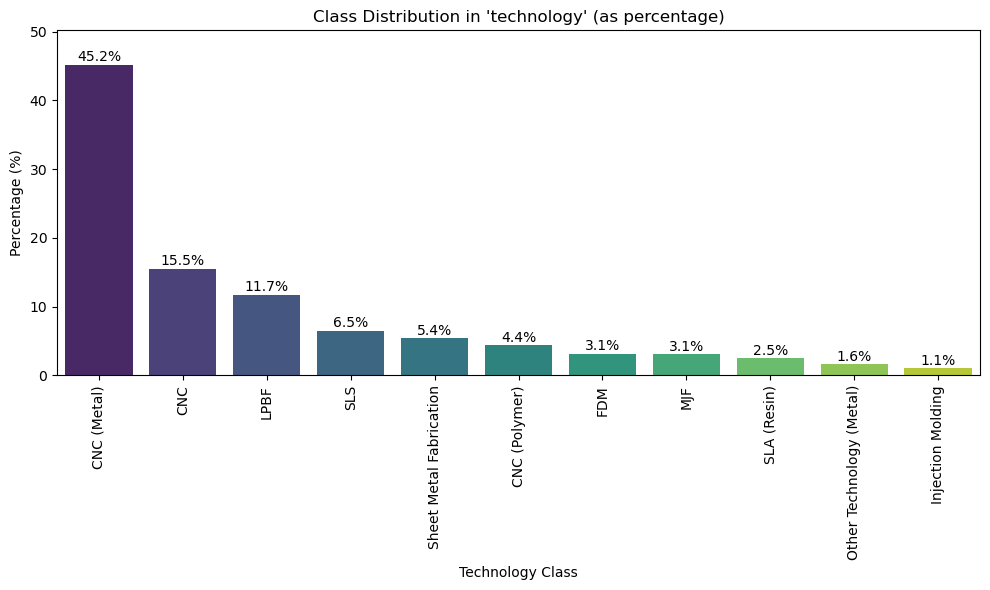

In [73]:
plot_class_distribution(data)

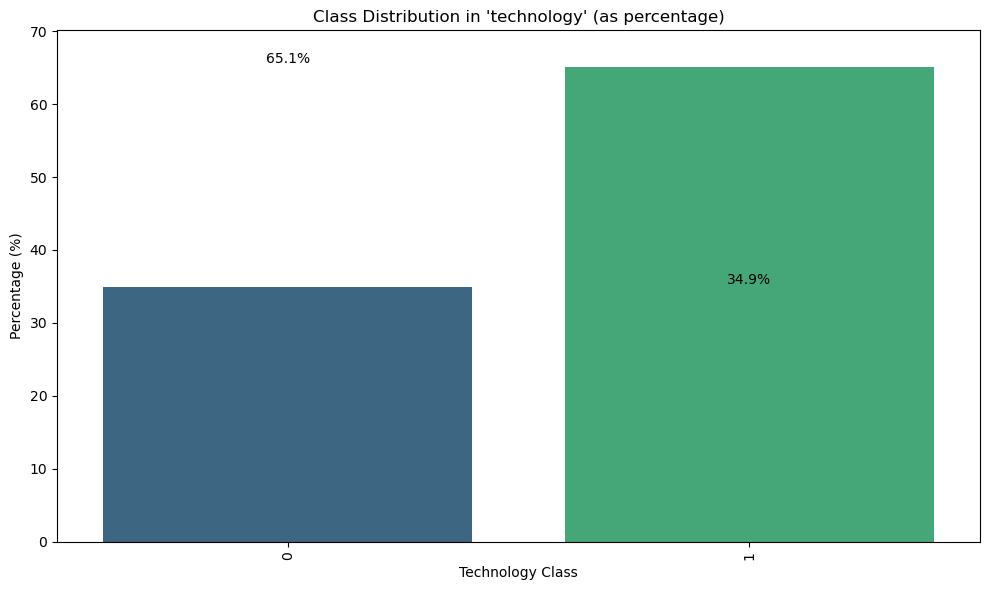

In [76]:
plot_class_distribution(data, target_col="Is_CNC")

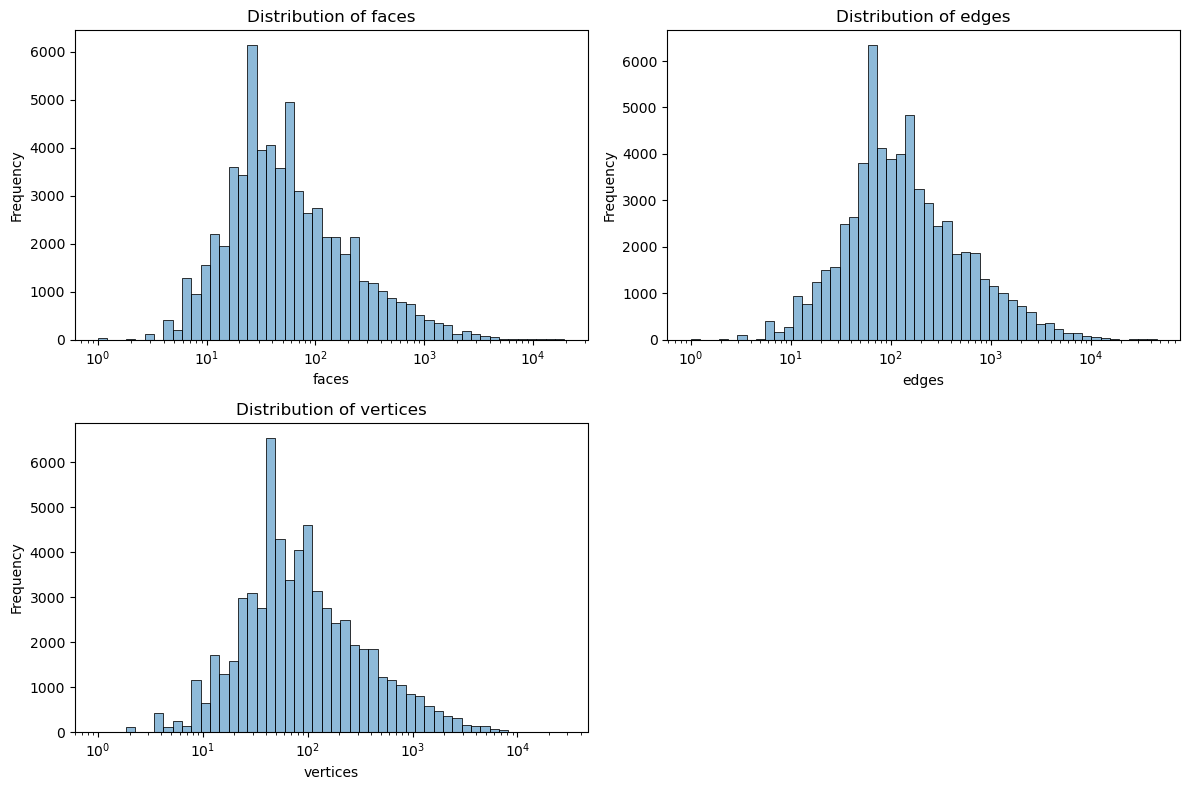

In [75]:
plot_topological_features_distribution(data, ["faces", "edges", "vertices"])

In [77]:
data.Is_CNC.value_counts()

Is_CNC
1    41019
0    21987
Name: count, dtype: int64

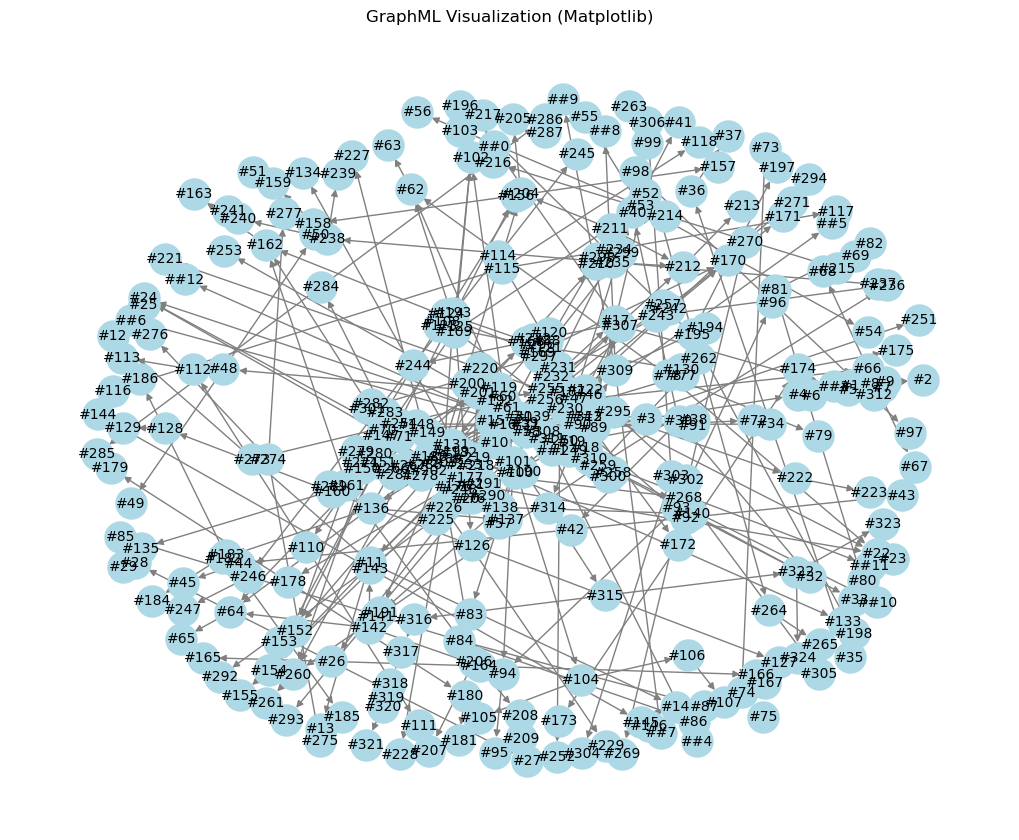

<Figure size 640x480 with 0 Axes>

In [5]:
display_graphml_matplotlib(r"E:\gnn_data\square_pocket\square_pocket.graphml")
# Save graph plot to file


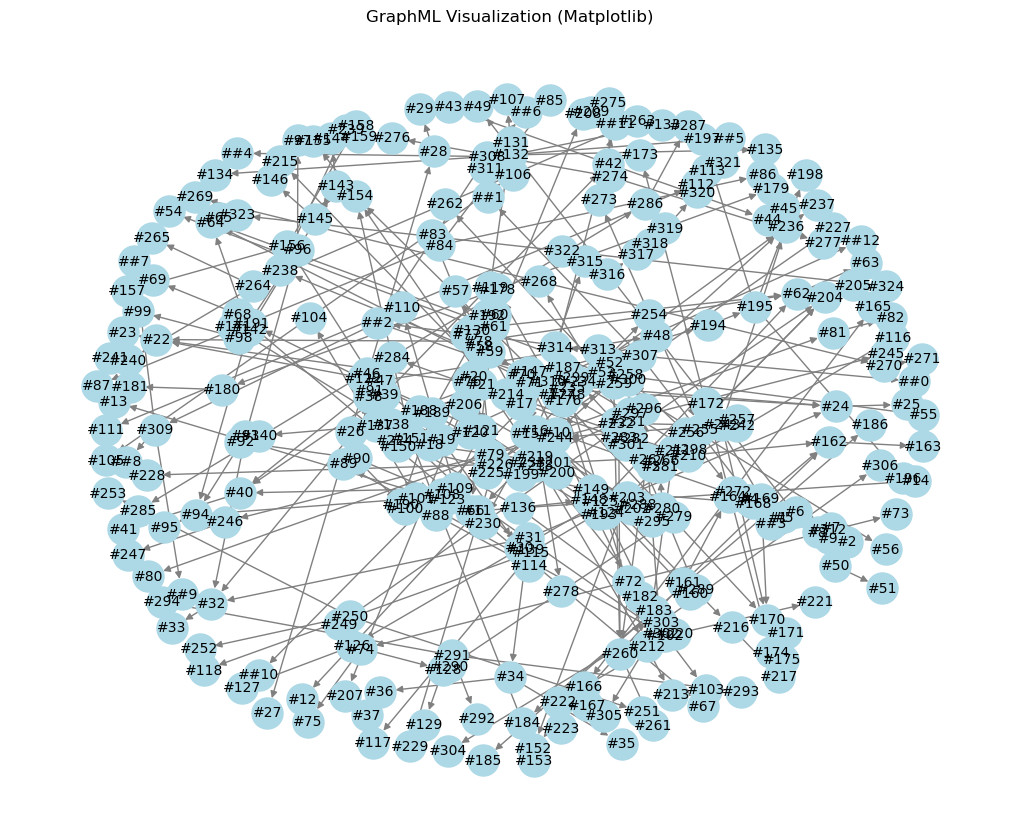

In [6]:
G = nx.read_graphml(r"E:\gnn_data\square_pocket\square_pocket.graphml")
# Choose layout
pos = nx.spring_layout(G)
# Draw the graph
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=500, font_size=10)
plt.title("GraphML Visualization (Matplotlib)")
plt.savefig("E:\gnn_data\square_pocket\square_pocket.png")

In [7]:
G = nx.read_graphml(r"E:\gnn_data\square_pocket\square_pocket.graphml")
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


Number of nodes: 337
Number of edges: 396


In [14]:
for node in G.neighbors("#3"):
    print(node)

#4
#10


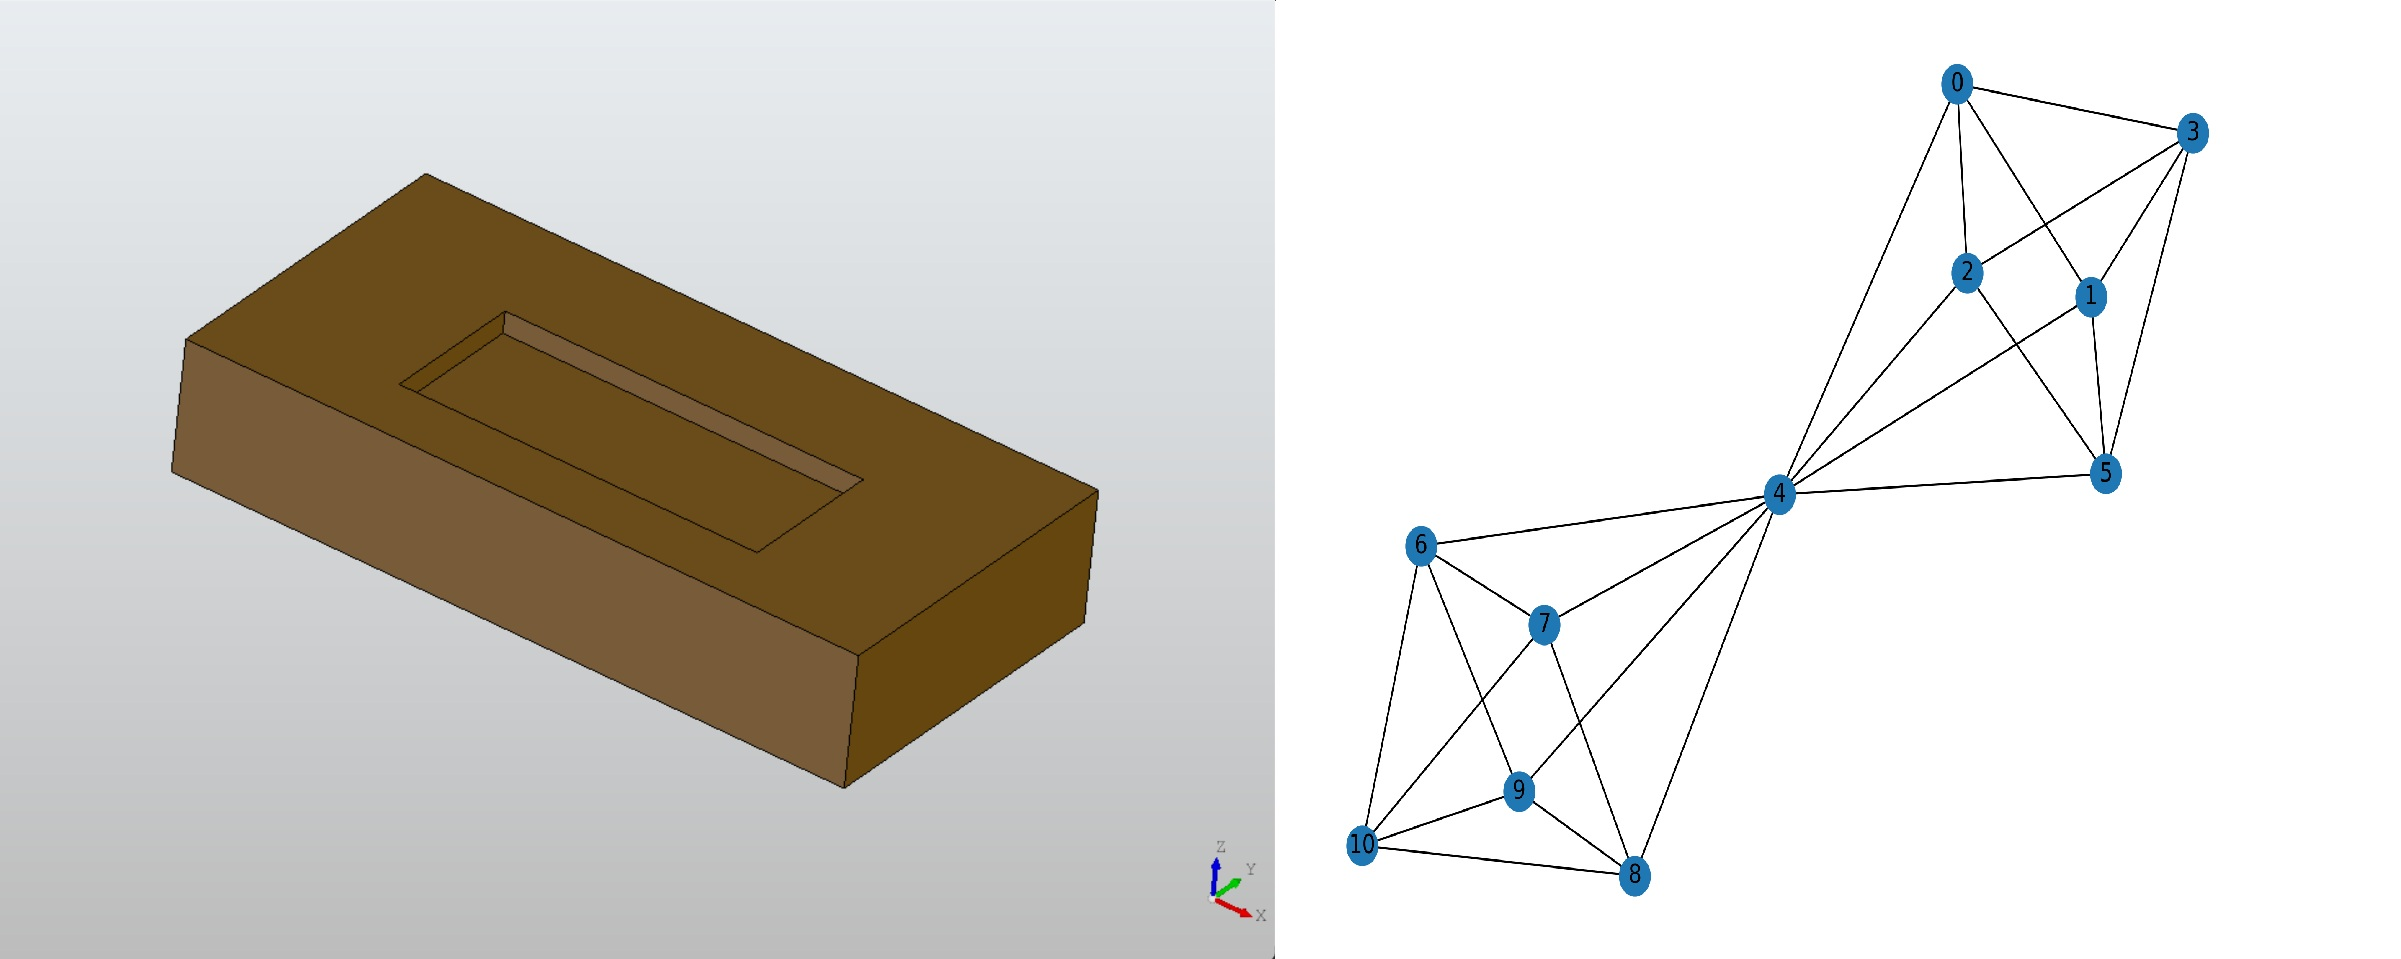

In [7]:
# display image from disk
display(Image(r"E:\graph_conversion.jpg"))

In [8]:
G = nx.read_graphml(r"E:\gnn_data\graphml_files_v2\square_pocket.graphml")
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 11
Number of edges: 24


In [33]:
for index, node in enumerate(G.nodes()):
    if index == 4 or index ==3:
        G.nodes[node]['color'] = 'lightblue'
    else:
        G.nodes[node]['color'] = 'gray'

In [34]:
node_colors = [data['color'] for node, data in G.nodes(data=True)]

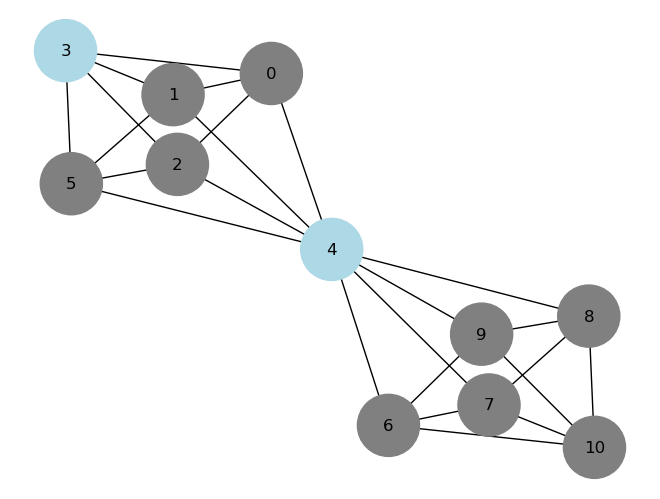

In [36]:
nx.draw(G, node_size=2000, node_color=node_colors, with_labels=True)
plt.savefig("E:\square_pocket.png", dpi=160)

In [31]:
df_na = df.dropna()

In [1]:
xgboost_scores = [0.83, 0.81, 0.80, 0.79, 0.82]
pointnet_scores = [0.84, 0.86, 0.83, 0.85, 0.87]
from scipy.stats import ttest_rel
ttest_rel(xgboost_scores, pointnet_scores)

TtestResult(statistic=-4.472135954999578, pvalue=0.011056493393450087, df=4)

In [13]:
data = pd.read_csv("./data/synced_dataset_final.csv")
data.iloc[0]["item_id"]

numpy.int64

In [6]:
data[data.file_name.str.startswith("23580_006")]

,item_id,faces,edges,vertices,file_name,depth,width,height,area,volume,...,download_file_url,technology_name,is_cnc,multiclass_labels,graphml_file,pointcloud_file,binary_fold,multiclass_fold,file_size,step_file_path
15886,23580,27.0,68.0,42.0,23580_006_TopCoverRFID_Magnelis_3mm_test.STEP,4.0,154.199997,184.850006,55587.419272,100869.209004,...,https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\23580_006_TopCoverRF...,E:\gnn_data\pointcloud_files\23580_006_TopCove...,0.0,2.0,59189,E:\gnn_data\step_files\23580_006_TopCoverRFID_...


In [36]:
import os

data['step_file_path'] = data['file_name'].map(lambda x: os.path.join(r"E:\gnn_data\step_files", x))


In [38]:
data['file_size'] = data['step_file_path'].map(os.path.getsize)

In [ ]:
data.head()

In [49]:
data.to_csv("./data/synced_dataset.csv", index=False)

In [32]:
data[data.file_size == 0]

,item_id,faces,edges,vertices,file_name,depth,width,height,area,volume,...,post_processing_id,download_file_url,technology_name,is_cnc,multiclass_labels,graphml_file,pointcloud_file,binary_fold,multiclass_fold,file_size
326,100498,60.0,140.0,91.0,100498_10199000001120240417_tz_extruder_victor...,148.109545,46.334813,46.03492,33365.703787,124584.383076,...,[277],https://prod-mv-user-files-upload.s3.eu-centra...,CNC (Metal),1,2,E:\gnn_data\graphml_files\100498_1019900000112...,E:\gnn_data\pointcloud_files\100498_1019900000...,4.0,8.0,0


In [57]:
import torch.nn as nn
import torch
embed = nn.Embedding(392, 32)

In [58]:
with open(r"type_embedding.pkl", "wb") as f:
    joblib.dump(embed, f)

In [49]:
label = 0
type_embedding = joblib.load(r"type_embedding.pkl")
with open(r"all_attribute_type.pkl", "rb") as f:
    all_attribute_type = sorted(list(joblib.load(f)))
node_type_index = {node_type: idx for idx, node_type in enumerate(all_attribute_type)}

In [50]:
graphml_path = r"E:\gnn_data\graphml_files\65905_Stator_1030_segmented_end_round.graphml"
G = nx.read_graphml(graphml_path)
data = enhanced_convert_graph(G, label, node_type_index, type_embedding)

WTF IS GOING ON


In [54]:
data.x

tensor([[ 2.0000e+00,  2.9155e-03,  0.0000e+00,  ...,  1.0515e+00,
         -7.0160e-01, -1.8312e-01],
        [ 3.0000e+00,  4.3732e-03,  0.0000e+00,  ...,  1.2171e+00,
          7.7657e-02,  5.7191e-02],
        [ 2.0000e+00,  2.9155e-03,  5.8479e-05,  ..., -1.1482e+00,
         -1.2018e+00, -8.5696e-01],
        ...,
        [ 2.0000e+00,  2.9155e-03,  1.4620e-05,  ..., -9.0642e-01,
         -4.2574e-01,  3.2128e-01],
        [ 1.0000e+00,  1.4577e-03,  0.0000e+00,  ..., -2.8646e+00,
          6.4150e-01,  1.4129e+00],
        [ 3.0000e+00,  4.3732e-03,  0.0000e+00,  ...,  9.8768e-01,
         -8.3197e-01,  1.2299e+00]])

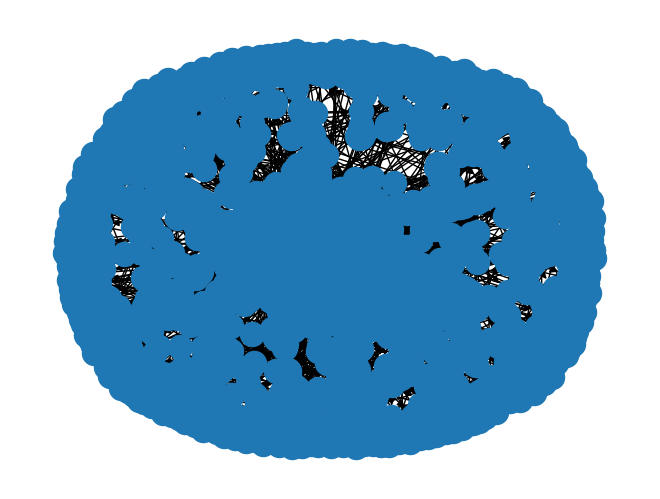

In [61]:
graphml_path_2 = r"E:\gnn_data\graphml_files\23524_775_740_50_2902_1__.graphml"
G2 = nx.read_graphml(graphml_path_2)
nx.draw(G2)

In [66]:
sample = torch.load(r"E:\gnn_data\processed_step_data_global_features\23571_blockonesidefillet.pt", weights_only=False)
sample.x[:, 1:]

tensor([[2.0000e+00, 4.0000e-03, 8.0321e-05, 5.9701e-03, 1.7460e-03, 0.0000e+00],
        [1.0000e+00, 2.0000e-03, 0.0000e+00, 1.3032e-02, 4.9247e-03, 0.0000e+00],
        [4.0000e+00, 8.0000e-03, 1.2048e-04, 4.9655e-03, 2.1840e-03, 0.0000e+00],
        ...,
        [2.0000e+00, 4.0000e-03, 1.2717e-04, 4.7606e-03, 1.4211e-03, 3.0000e+00],
        [1.0000e+00, 2.0000e-03, 0.0000e+00, 1.0194e-02, 4.2074e-03, 0.0000e+00],
        [1.0000e+00, 2.0000e-03, 0.0000e+00, 4.7606e-03, 1.5758e-03, 0.0000e+00]])

In [3]:
from pathlib import Path
step_dir = set(file.stem for file in list(Path(r"E:\gnn_data\step_files").glob("*.*")))
graph_dir = set(file.stem for file in list(Path(r"E:\gnn_data\graphml_files").glob("*.*")))
step_dir - graph_dir

{'123905_DE070000_A', '56431_KomRad'}

In [4]:
with open(r"E:\gnn_data\pyg_data_v2_scaled\dataset_mapping.pkl", "rb") as f:
    dataset_mapping = joblib.load(f)

In [5]:
dataset_mapping.keys()

dict_keys(['processed_files', 'failed_files', 'total_original', 'total_processed', 'total_failed'])

In [14]:
dataset_mapping["processed_files"]

[{'original_path': 'E:\\gnn_data\\graphml_files\\100035_MakerVerse_Sample.graphml',
  'processed_path': 'E:\\gnn_data\\pyg_data_v2\\100035_MakerVerse_Sample.pt',
  'label': 1,
  'index': 0},
 {'original_path': 'E:\\gnn_data\\graphml_files\\100041_00048495_Table_Level_step_001.graphml',
  'processed_path': 'E:\\gnn_data\\pyg_data_v2\\100041_00048495_Table_Level_step_001.pt',
  'label': 1,
  'index': 3},
 {'original_path': 'E:\\gnn_data\\graphml_files\\100042_00048569_Seal_Holder_step_002.graphml',
  'processed_path': 'E:\\gnn_data\\pyg_data_v2\\100042_00048569_Seal_Holder_step_002.pt',
  'label': 1,
  'index': 4},
 {'original_path': 'E:\\gnn_data\\graphml_files\\100044_00048893_Fixture1_step_001.graphml',
  'processed_path': 'E:\\gnn_data\\pyg_data_v2\\100044_00048893_Fixture1_step_001.pt',
  'label': 1,
  'index': 6},
 {'original_path': 'E:\\gnn_data\\graphml_files\\100043_00048835_Bracket_step_000.graphml',
  'processed_path': 'E:\\gnn_data\\pyg_data_v2\\100043_00048835_Bracket_step_0

In [18]:
import copy
dataset_mapping_new = copy.deepcopy(dataset_mapping)
dataset_mapping_new["processed_files"] = [
    {key: value.replace("pyg_data_v2", "pyg_data_v2_scaled")
     if key == "processed_path" else value
     for key, value in item.items()}
    for item in dataset_mapping["processed_files"]
]

In [21]:
with open(r"E:\gnn_data\pyg_data_v2_scaled\dataset_mapping.pkl", "wb") as f:
    joblib.dump(dataset_mapping_new, f)

In [15]:
import os
import shutil
from pathlib import Path

# Paths
pt_root = Path("E:\gnn_data\pyg_data_v2_scaled_validation_fold_01")            # Folder containing fold_00, fold_01, ...
txt_root = Path("E:\gnn_data\pointcloud_files")       # Folder containing all .txt files
output_root = Path("E:\gnn_data\pointcloud_files_folds")

# Create output root if not exists
output_root.mkdir(exist_ok=True)

# Loop through folds in the pt dataset
for fold_dir in pt_root.glob("fold_*"):
    fold_name = fold_dir.name
    txt_fold_dir = output_root / fold_name
    txt_fold_dir.mkdir(parents=True, exist_ok=True)

    # For each .pt file in the fold, find matching .txt file
    for pt_file in fold_dir.glob("*.pt"):
        base_name = pt_file.stem  # filename without extension
        txt_file = txt_root / f"{base_name}.txt"

        if txt_file.exists():
            shutil.copy(txt_file, txt_fold_dir / txt_file.name)